In [1]:
import os
import pandas as pd

In [2]:
def sn_construct(input_):
    ## from https://github.com/google/compare_gan/blob/master/compare_gan/src/gans/ops.py
    
    """Performs Spectral Normalization on a weight tensor."""
    if len(input_.shape) < 2:
        raise ValueError(
            "Spectral norm can only be applied to multi-dimensional tensors")

    # The paper says to flatten convnet kernel weights from (C_out, C_in, KH, KW)
    # to (C_out, C_in * KH * KW). But Sonnet's and Compare_gan's Conv2D kernel
    # weight shape is (KH, KW, C_in, C_out), so it should be reshaped to
    # (KH * KW * C_in, C_out), and similarly for other layers that put output
    # channels as last dimension.
    # n.b. this means that w here is equivalent to w.T in the paper.
    w = tf.reshape(input_, (-1, input_.shape[-1]))

    # Persisted approximation of first left singular vector of matrix `w`.
    
    #print input_.name
    u_var = tf.get_variable(
      input_.name.replace(":", "") + "/u_var",
      shape=(w.shape[0], 1),
      dtype=w.dtype,
      initializer=tf.random_normal_initializer(),
      trainable=False)
    u = u_var
    #print u_var.name
    # Use power iteration method to approximate spectral norm.
    # The authors suggest that "one round of power iteration was sufficient in the
    # actual experiment to achieve satisfactory performance". According to
    # observation, the spectral norm become very accurate after ~20 steps.

    power_iteration_rounds = 1
    for _ in range(power_iteration_rounds):
        # `v` approximates the first right singular vector of matrix `w`.
        v = tf.nn.l2_normalize(
            tf.matmul(tf.transpose(w), u), axis=None, epsilon=1e-12)
        u = tf.nn.l2_normalize(tf.matmul(w, v), axis=None, epsilon=1e-12)

        # Update persisted approximation.
    with tf.control_dependencies([tf.assign(u_var, u, name="update_u")]):
        u = tf.identity(u)

    # The authors of SN-GAN chose to stop gradient propagating through u and v.
    # In johnme@'s experiments it wasn't clear that this helps, but it doesn't
    # seem to hinder either so it's kept in order to be a faithful implementation.
    u = tf.stop_gradient(u)
    v = tf.stop_gradient(v)

    # Largest singular value of `w`.
    norm_value = tf.matmul(tf.matmul(tf.transpose(u), w), v)
    norm_value.shape.assert_is_fully_defined()
    norm_value.shape.assert_is_compatible_with([1, 1])
    
    w_normalized = w / norm_value

    # Unflatten normalized weights to match the unnormalized tensor.
    w_tensor_normalized = tf.reshape(w_normalized, input_.shape)    
    return u_var, u, v, norm_value, w_tensor_normalized

In [3]:
fns = os.listdir('../processed_data/adj_expression/')

In [4]:
with open('../processed_data/model_genes.txt', 'rb') as reader:
    selected_genes = set([s.strip() for s in reader.readlines()])

In [5]:
f = fns[0]
tissue = f.split('-')[0]
df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0, nrows = 5)    
id2gene = [str(s) for s in df_exp.columns if s.split('.')[0] in selected_genes]
assert(len(id2gene) == len(selected_genes))

In [6]:
len(id2gene)

11890

In [7]:
data = []
id2tissue = []
for i, f in enumerate(fns):
    tissue = f.split('-')[0]
    df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0)
    df_exp = df_exp[id2gene]
    data.append(df_exp.values)
    id2tissue += [tissue] * df_exp.shape[0]

In [8]:
len(id2tissue)

7051

In [9]:
import numpy as np
data = np.vstack(data)

In [10]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf


In [11]:
def DNN(x, theta_mat, is_train, scope = 'linear', reuse = tf.AUTO_REUSE):
    h_in = x 
    with tf.variable_scope(scope, reuse=reuse):
        for i, n_node in enumerate(theta_mat):
            h_out = tf.layers.dense(h_in, n_node, name = 'h%02d/dense' % i, use_bias=False)
            h_in = h_out
            #
            if (i > 0) and ((i+1) != len(theta_mat)):
                h_in = tf.layers.batch_normalization(h_in, training=is_train, name = 'h%02d/batch_norm' % i)
                h_in = tf.layers.dropout(h_in, rate=0.5, training=is_train)
            #h_in = tf.nn.relu(h_in) 
            h_in = tf.nn.tanh(h_in)   
    return h_out

In [12]:
num_gene = len(id2gene)

In [13]:
data.shape

(7051, 11890)

In [14]:
num_sample = data.shape[0]

ind_train = np.array([i for i in range(num_sample) if i % 20 != 0])
ind_test = np.array([i for i in range(num_sample) if i % 20 == 0])

train_data = data[ind_train, :].astype('float32')
test_data = data[ind_test, :].astype('float32')

num_sample = train_data.shape[0]

In [62]:
beta1 = 0.9

with tf.device("/gpu:0"):
    tf.reset_default_graph()
    
    ##========================= define inputs ===========================##
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    l1_penalty = tf.placeholder(tf.float32, name = 'l1_penalty')
    
    inputs = tf.placeholder(tf.float32, [None, num_gene], 
                            name='inputs')
    
    ## net for inference
    theta_mat = [512, num_gene]
    w0_tf = tf.get_variable('w0_tf', [theta_mat[1], theta_mat[0]])
    w1_tf = tf.get_variable('w1_tf', [theta_mat[0], theta_mat[1]])
    
    #w1n_tf = w1_tf / tf.stop_gradient(tf.linalg.norm(w1_tf))
    _, _, _, _, w1n_tf = sn_construct(w1_tf)
    w1n_tf = w1n_tf / np.sqrt(float(theta_mat[0]))
    #w1n_tf = w1_tf / tf.linalg.norm(w1_tf)
    
        
    h0 = tf.matmul(inputs, w0_tf, name = 'h0')
    logit_rec = tf.matmul(h0, w1n_tf, name = 'h1')
    
    rec_loss_l2 = tf.reduce_mean(tf.square(logit_rec - inputs))
    
    ## net for training, data loaded on GPU to save computation
    inputs_train = tf.constant(train_data, name = 'input_training')
    inputs_train += tf.random.normal(tf.shape(inputs_train), mean=0.0, stddev=.1)
    
    h0_train = tf.matmul(inputs_train, w0_tf, name = 'h0_train')
    logit_rec_train = tf.matmul(h0_train, w1n_tf, name = 'h1_train')
    
    rec_loss_l2_train = tf.reduce_mean(tf.square(logit_rec_train - inputs_train))
    
    d_loss = rec_loss_l2_train + l1_penalty * tf.reduce_mean(tf.abs(w0_tf))
    
    
    d_lrd = tf.placeholder(tf.float32, name = 'd_lrd')
    
    d_optim = tf.train.AdamOptimizer(d_lrd, beta1=beta1)  
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_op = d_optim.minimize(d_loss)


In [63]:
sn_ops = [op for op in tf.get_default_graph().get_operations() if 'update_u' in op.name]

In [64]:
sess = tf.Session()

In [65]:
sess.run(tf.global_variables_initializer())

In [82]:
iter_counter = 0
errD, errG, D_count, G_count = 0.0, 0.0, 0.0, 0.0

num_batch = num_sample

for idx in range(20000):
    lrd = 1e-3 / np.sqrt(idx * 0.005 + 1.0)
    #l1_val = 1000.0
    l1_val = 5.
        
    # updates the discriminator
    feed_dict={is_training:True,
               l1_penalty: l1_val,
               #noise_level: 0.05, 
               d_lrd: lrd,
                }
        
    val, _ = sess.run([rec_loss_l2_train, d_train_op], feed_dict=feed_dict)
    sess.run(sn_ops)   
    
    errD += val
    D_count += 1.0
        
            
    if idx % 100 == 0:
        errD = errD / D_count

        feed_dict={inputs: test_data, 
               is_training:False,
               }            

        test_errD1 = sess.run(rec_loss_l2, feed_dict=feed_dict)
        

        msr = "iter: %4d, train_loss: %.4f, test_loss: %.4f" \
            % (idx, errD,test_errD1)
        print(msr)
        errD, errG, D_count, G_count = 0.0, 0.0, 0.0, 0.0
            
        iter_counter += 1

iter:    0, train_loss: 0.5386, test_loss: 0.6322
iter:  100, train_loss: 0.5903, test_loss: 0.6951
iter:  200, train_loss: 0.6448, test_loss: 0.7160
iter:  300, train_loss: 0.6645, test_loss: 0.7241
iter:  400, train_loss: 0.6726, test_loss: 0.7277
iter:  500, train_loss: 0.6759, test_loss: 0.7283
iter:  600, train_loss: 0.6775, test_loss: 0.7293
iter:  700, train_loss: 0.6785, test_loss: 0.7295
iter:  800, train_loss: 0.6785, test_loss: 0.7279
iter:  900, train_loss: 0.6783, test_loss: 0.7277


KeyboardInterrupt: 

In [83]:
w0_val = sess.run(w0_tf)

In [84]:
np.sum(np.abs(w0_val) < 5e-7) / float(w0_val.size)

0.00388029594196804

In [85]:
np.mean(np.abs(w0_val))

0.035643827

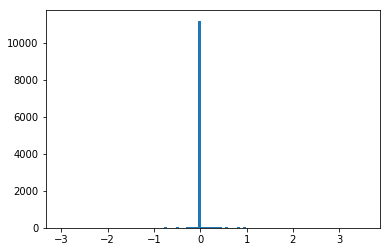

In [86]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(w0_val[:, 1], bins = 100)
plt.show()

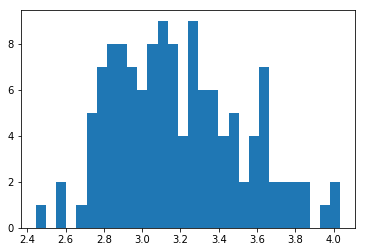

In [87]:
plt.hist([np.max(np.abs(w0_val[:, i])) for i in range(128)], bins = 30)
plt.show()

In [88]:
np.abs(w0_val[:, 0]).max()

3.5219166

In [89]:
from statsmodels import robust

In [90]:
for i in range(100):
    thre = max((0.01 * np.abs(w0_val[:, i])).max(), 1e-5)
    #thre = 3.0 * w0_val[:, i].std()
    #thre = 1.8 * robust.mad(w0_val[:, i])
    #thre = 1e-5
    print i, np.sum(np.abs(w0_val[:, i]) > thre ), thre, np.max(np.abs(w0_val[:, i]))

0 655 0.035219166 3.5219166
1 682 0.03560869 3.5608692
2 637 0.02792976 2.7929761
3 654 0.030051207 3.0051208
4 713 0.031103358 3.1103358
5 499 0.030302754 3.0302753
6 692 0.03642771 3.6427712
7 676 0.032435574 3.2435575
8 741 0.03351923 3.3519232
9 732 0.038449004 3.8449004
10 683 0.030223694 3.0223694
11 704 0.03697213 3.6972134
12 628 0.031695936 3.1695938
13 608 0.024442399 2.4442399
14 586 0.031845454 3.1845455
15 714 0.038062386 3.8062387
16 637 0.03420383 3.4203832
17 571 0.036430463 3.6430464
18 604 0.0277695 2.7769501
19 650 0.030465122 3.0465124
20 601 0.03288779 3.288779
21 564 0.03626088 3.6260881
22 671 0.028747572 2.8747573
23 770 0.033699922 3.3699923
24 624 0.030189564 3.0189564
25 672 0.032814894 3.2814894
26 564 0.029718813 2.9718814
27 633 0.03312105 3.312105
28 665 0.027488722 2.7488723
29 767 0.028761102 2.8761103
30 582 0.028052814 2.8052814
31 596 0.02866586 2.866586
32 576 0.030109512 3.0109513
33 528 0.028779099 2.87791
34 679 0.029119305 2.9119306
35 730 0.028

In [40]:
gene_mat = np.zeros(w0_val.shape)

for i in range(512):
    thre = (0.001 * np.abs(w0_val[:, i])).max()
    gene_mat[:, i] = np.abs(w0_val[:, i]) > thre

In [42]:
gene_mat.sum(axis = 1)

array([10., 15.,  8., ...,  8.,  8.,  9.])

/data1/users/hclee/hclee/python2/local/lib/python2.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

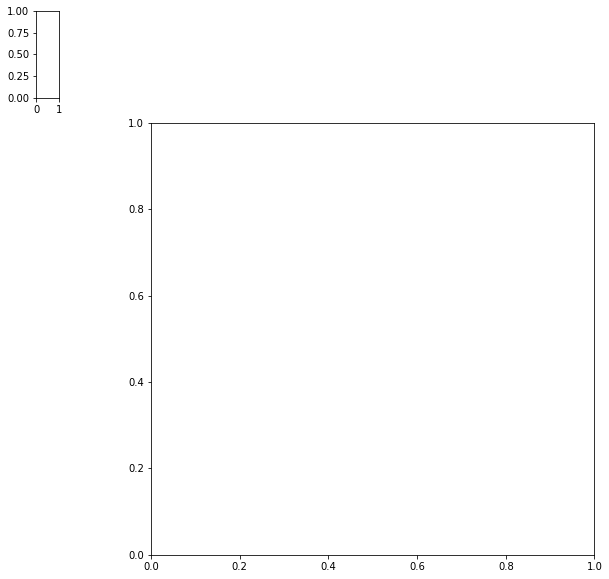

In [111]:
import seaborn.apionly as sns

sns.clustermap(w0_val, cmap = 'RdBu_r')
plt.show()

In [ ]:
sns.clustermap(test_data.dot(w0_val), cmap = 'RdBu_r')
plt.show()

In [163]:
import pickle
with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)

In [176]:
i = 21
thre = (0.001 * np.abs(w0_val[:, i])).max()

for i in np.where(np.abs(w0_val[:, i]) > thre)[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

YBX1
MOV10
C1orf43
DNA2
FAM53B
CPSF7
BSCL2
VEGFB
RPAP3
ESYT1
ATXN7L3B
TMED10
ENSG00000068793
MAP1A
PRMT7
COG1
EML2
TRPM4
NUP62
ZNF468
TTC31
SRC
ACOT8
ANO10
NCKIPSD
P4HTM
DALRD3
AMT
HYAL3
NAT6
WDR1
EXOC2
RPL7L1
PEX6
GTF3C6
DAGLB
FAM188B
YWHAG
TRIM4
COG5
TTI2
CRAT


In [93]:
feed_dict={inputs: test_data, 
           is_training:False,
           l1_penalty: l1_val,
           #noise_level: 0.05, 
           d_lrd: lrd,
            }

rec_val = sess.run(logit_rec, feed_dict=feed_dict)

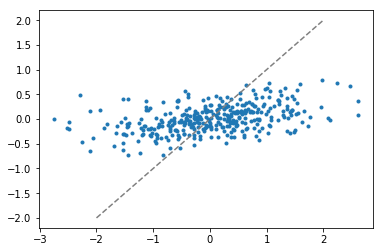

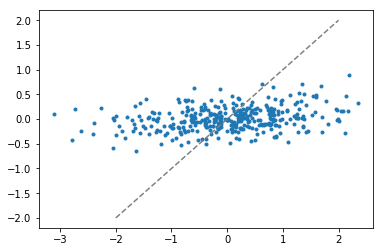

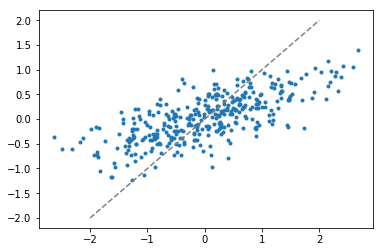

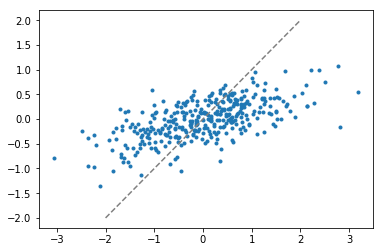

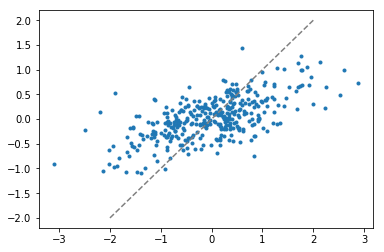

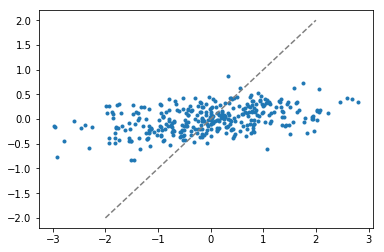

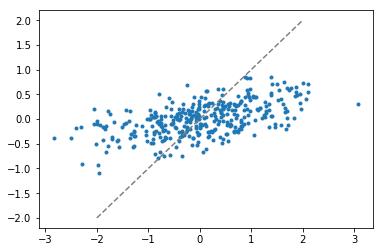

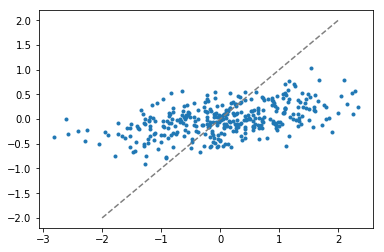

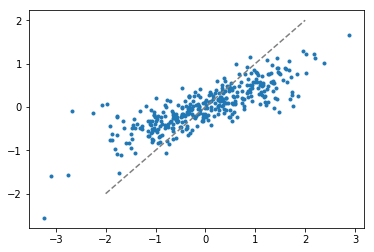

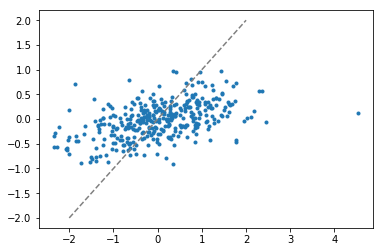

In [94]:
for i in range(0, 100, 10):
    plt.plot(test_data[:, i], rec_val[:, i], '.')
    plt.plot([-2.0, 2.0], [-2.0, 2.0], '--', color = 'gray')
    plt.show()

In [20]:
from sklearn.decomposition import PCA
clf = PCA(n_components = 128)

In [21]:
clf.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=128, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
clf.explained_variance_ratio_.sum()

0.27107614

In [23]:
test_rec = clf.inverse_transform(clf.transform(test_data))

In [24]:
np.mean((test_rec - test_data) ** 2)

0.75110865

In [25]:
train_rec = clf.inverse_transform(clf.transform(train_data))
np.mean((train_rec - train_data) ** 2)

0.7247935